# Imports

In [424]:
import pathlib
from pathlib import Path
import sys

_here = Path().resolve().parent.parent
# print(_here,str(_here))
sys.path.append(str(_here))


import os
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score   
import time

from typing import List, Dict, Union, Optional, Tuple
import torch
import torch.nn as nn
import torchcde
from torch.utils.data import Dataset, DataLoader

from src.data.cde_transforms import insert_random_missingness, preprocess_for_transformer
# from src.models.RNNModel import RNNModel, RNNModelReg
# from src.models.LSTMModel import LSTMModel

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Setting model hyperparameters

In [456]:
HP = {
    'run_RNN' : True,
    'run_LSTM' : True,
    'batch_size': 32,
}

# Hyperparameters for the RNN model
RNNHP = {
    "input_dim": 3,
    "hidden_dim": 104,
    "layer_dim": 1,
    "output_dim": 3,
    "lr": 0.001,
    "epochs": 500,
    "patience": 100
}

# Hyperparameters for the LSTM model
LSTMHP = {
    "input_dim": 3,
    "hidden_dim": 50,
    "layer_dim": 1,
    "output_dim": 3,
    "lr": 0.001,
    "epochs": 500,
    "patience": 100
}

# Retrieving the data

## helper method for getting the length of the given input

In [426]:
def getLenghts(inputs):
    # inputs is a tensor of size batch * 182 * 4
    # returns a list of size batch, indicating the true sequence length of each batch
    lengths = []
    for i in range(inputs.shape[0]):
        for j in range(1,inputs.shape[1]+1):
            if j == inputs.shape[1] or inputs[i][j][0] == 0:
                lengths.append(j)
                break

    return torch.tensor(lengths, dtype=torch.long).cpu()


## Initializing Datasets

In [428]:
CharacterTrajectoriesDataPath = str(_here) + "/data/processed/CharacterTrajectories/regression/30"

x_train = torch.load(CharacterTrajectoriesDataPath + "/X_train.pt").float()
y_train = torch.load(CharacterTrajectoriesDataPath + "/y_train.pt").float()
x_test = torch.load(CharacterTrajectoriesDataPath + "/X_test.pt").float() 
y_test = torch.load(CharacterTrajectoriesDataPath + "/y_test.pt").float()

def merge(x_train, y_train):
    x_lengths = getLenghts(x_train)
    y_lengths = getLenghts(y_train)
    
    new_x_train = torch.zeros(x_train.size(0), x_train.size(1)+y_train.size(1), x_train.size(2))
    
    for i in range(x_train.size(0)):
        new_x_train[i][:x_lengths[i]] = x_train[i][:x_lengths[i]]
        new_x_train[i][x_lengths[i]:x_lengths[i]+y_lengths[i]] = y_train[i][:y_lengths[i]]

    new_y_train = new_x_train[:, 1:, :]  # Shift y_train by one step
    new_x_train = new_x_train[:, 0:-1, :]

    return new_x_train, new_y_train

x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

print(x_train.shape)
print(y_train.shape)
# x_train, y_train = merge(x_train, y_train)

print("x_train and y_train final shape")
print(x_train.shape)
print(y_train.shape)
print(f" first 5 {x_train[0,0:5,:]}, \ny first 5{y_train[0,0:5,:]}")

print("x_test and y_test final shape")
print(x_test.shape)
print(y_test.shape)

# Split train set into train and validation
val_size = int(0.2 * len(x_train))
x_train, x_val = x_train[:-val_size], x_train[-val_size:]
y_train, y_val = y_train[:-val_size], y_train[-val_size:]



class CharacterTrajectoriesDataset(Dataset):
    def __init__(self, x, y, get_lengths):
        self.x = x
        self.y = y
        self.get_lengths = get_lengths

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def collate_fn(batch):
        x, y = zip(*batch)
        x = torch.stack(x).to(device)
        lengths = getLenghts(x)
        y = torch.stack(y).to(device)
        return x[:,:,1:], y[:,:,1:], lengths # remove timepoint

train_dataset = CharacterTrajectoriesDataset(x_train, y_train, getLenghts)
val_dataset = CharacterTrajectoriesDataset(x_val, y_val, getLenghts)
test_dataset = CharacterTrajectoriesDataset(x_test, y_test, getLenghts)

train_loader = DataLoader(train_dataset, batch_size=HP['batch_size'], shuffle=True, collate_fn=CharacterTrajectoriesDataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=HP['batch_size'], shuffle=True, collate_fn=CharacterTrajectoriesDataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=HP['batch_size'], shuffle=False, collate_fn=CharacterTrajectoriesDataset.collate_fn)


torch.Size([2287, 127, 4])
torch.Size([2287, 55, 4])
x_train and y_train final shape
torch.Size([2287, 127, 4])
torch.Size([2287, 55, 4])
 first 5 tensor([[ 0.0000, -0.2495,  0.1904,  0.8064],
        [ 1.0000, -0.3399,  0.2421,  1.0169],
        [ 2.0000, -0.4191,  0.2734,  1.1379],
        [ 3.0000, -0.4834,  0.2817,  1.1640],
        [ 4.0000, -0.5377,  0.2700,  1.1278]], device='cuda:0'), 
y first 5tensor([[ 7.4000e+01, -1.2518e+00, -6.9150e-01,  1.0679e-02],
        [ 7.5000e+01, -1.1715e+00, -7.9041e-01, -3.3193e-02],
        [ 7.6000e+01, -1.0655e+00, -8.7148e-01, -1.0767e-01],
        [ 7.7000e+01, -9.3591e-01, -9.3448e-01, -2.3063e-01],
        [ 7.8000e+01, -7.8581e-01, -9.7979e-01, -4.2459e-01]], device='cuda:0')
x_test and y_test final shape
torch.Size([571, 127, 4])
torch.Size([571, 55, 4])


## Models

In [429]:

class RNNModelReg(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModelReg, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, lengths, hidden=None):
        # If no initial hidden state is provided, default to None (RNN will use zero state)
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out, hidden = self.rnn(x_packed, hidden)  # Pass the initial hidden state if provided
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = self.fc(out)
        return out, hidden  # Return both output and the last hidden state

class LSTMModelReg(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModelReg, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, lengths, hidden=None):
        # If no initial hidden state is provided, default to None (RNN will use zero state)
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out, hidden = self.lstm(x_packed, hidden)  # Pass the initial hidden state if provided
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = self.fc(out)
        return out, hidden  # Return both output and the last hidden state

# Train method

In [430]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=100, savePath="logs/lstm.pth"):
    best_val_mse = float("inf")
    best_params = None
    patience_counter = 0
    
    # Lists to store per-epoch loss and accuracy
    train_losses = []
    eval_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, lengths in train_loader:
            optimizer.zero_grad()
            y_lengths = getLenghts(y_batch)  
            
            # Processing the entire x_batch through the model to get the initial hidden state and outputs
            outputs, hidden = model(x_batch, lengths)
            
            # Select the last valid output for each sequence in the batch as the initial current input
            current_inputs = torch.stack([outputs[i, length-1, :] for i, length in enumerate(lengths)]).unsqueeze(1)

            # Initialize the placeholder for the entire sequence prediction
            y_pred_seq = torch.zeros_like(y_batch).to(device)
            
            # Set the first timestep predictions to the last output of x_batch
            for i in range(x_batch.size(0)):
                if y_lengths[i] > 0:  # Check if there's at least one timestep to predict
                    y_pred_seq[i, 0, :] = current_inputs[i, 0, :]
            
            max_pred_length = max(y_lengths).item()  # Assuming y_lengths is correctly defined
            current_length = torch.tensor([1] * x_batch.size(0))  # Each step is length 1
            for t in range(1, max_pred_length):  # Loop over the maximum prediction length across the batch
                output, hidden = model(current_inputs, current_length, hidden)
                current_inputs = output.clone()  # Prepare next input
                
                # Update predictions within the target length for each sequence
                for i, y_len in enumerate(y_lengths):
                    if t < y_len:  # Check if the current timestep is within the target sequence length
                        y_pred_seq[i, t, :] = output[i, :, :]

            loss = criterion(y_pred_seq, y_batch) / len(y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        avg_val_loss = evaluate(model, val_loader, criterion, wordToPrint="Val loss")
        eval_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.8f}, Val Loss: {avg_val_loss:.8f}')
        
        # Early Stopping Check
        if avg_val_loss < best_val_mse:
            best_val_mse = avg_val_loss
            patience_counter = 0
            best_params = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Stopping early due to no improvement in validation Acc.")
            break

    model.load_state_dict(best_params)
    # Save model
    torch.save(model.state_dict(),savePath )

    return train_losses, eval_losses


def evaluate(model, test_loader, criterion, wordToPrint="Test loss"):
    model.eval()
    total_val_loss = 0
    b = 0  # Counter for batches, used to print information from the first batch
    with torch.no_grad():
        for x_batch, y_batch, lengths in test_loader:
            
            y_lengths = getLenghts(y_batch)  
            
            # Processing the entire x_batch through the model to get the initial hidden state and outputs
            outputs, hidden = model(x_batch, lengths)
            
            # Select the last valid output for each sequence in the batch as the initial current input
            # print(f"input to evaluate, x_batch: {x_batch.shape}, lengths (of x): {lengths}, lengths (of y): {y_lengths} ")
            current_inputs = torch.stack([outputs[i, length-1, :] for i, length in enumerate(lengths)]).unsqueeze(1)
            # print(f"Outputs: {outputs.shape}, current_input: {current_inputs.shape}\n{current_inputs[:5,0,:]} ")

            # Initialize the placeholder for the entire sequence prediction
            y_pred_seq = torch.zeros_like(y_batch).to(device)
            
            # Set the first timestep predictions to the last output of x_batch
            for i in range(x_batch.size(0)):
                if y_lengths[i] > 0:  # Check if there's at least one timestep to predict
                    y_pred_seq[i, 0, :] = current_inputs[i, 0, :]
            
            max_pred_length = max(y_lengths).item()  # Assuming y_lengths is correctly defined
            current_length = torch.tensor([1] * x_batch.size(0))  # Each step is length 1
            for t in range(1, max_pred_length):  # Loop over the maximum prediction length across the batch
                output, hidden = model(current_inputs, current_length, hidden)
                current_inputs = output.clone()  # Prepare next input
                
                # Update predictions within the target length for each sequence
                for i, y_len in enumerate(y_lengths):
                    if t < y_len:  # Check if the current timestep is within the target sequence length
                        y_pred_seq[i, t, :] = output[i, :, :]

            loss = criterion(y_pred_seq, y_batch) / len(y_batch)
            total_val_loss += loss.item()
            # if b == 0:  # Print comparison for the first batch
            # print(f"Comparing predictions with output:\n y_pred\n{y_pred_seq[0,:5,:]} \ny_batch\n{y_batch[0,:5,:]}")
                # b += 1

    avg_val_loss = total_val_loss / len(test_loader)
    print(f'{wordToPrint}: {avg_val_loss}')

    return avg_val_loss

In [432]:
def plot_learning_curves(train_losses, eval_losses, title='Learning Curves'):
    # Extract the data for plotting
    iterations = list(range(1, len(train_losses) + 1))

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, train_losses, 'r-', label='Training Loss')
    plt.plot(iterations, eval_losses, 'b-', label='Validation Loss')
    plt.xlabel('Training Iterations')
    plt.ylabel('Loss')
    plt.title(title + ' - Loss')
    plt.legend(loc='upper left')
    plt.savefig(title + '_MSE_loss.png')  # Save the plot as a PNG file
    plt.show()



# Training

RNN Total number of parameters: 11651
Val loss: 0.015439633280038834
Epoch 1/500, Train Loss: 0.01646603, Val Loss: 0.01543963
Val loss: 0.015323714477320512
Epoch 2/500, Train Loss: 0.01246262, Val Loss: 0.01532371
Val loss: 0.01444403858234485
Epoch 3/500, Train Loss: 0.01218794, Val Loss: 0.01444404
Val loss: 0.01129894470795989
Epoch 4/500, Train Loss: 0.01032092, Val Loss: 0.01129894
Val loss: 0.011124915101875861
Epoch 5/500, Train Loss: 0.00973112, Val Loss: 0.01112492
Val loss: 0.011966613804300625
Epoch 6/500, Train Loss: 0.00947697, Val Loss: 0.01196661
Val loss: 0.011147747344026963
Epoch 7/500, Train Loss: 0.01039561, Val Loss: 0.01114775
Val loss: 0.010940895322710276
Epoch 8/500, Train Loss: 0.00925032, Val Loss: 0.01094090
Val loss: 0.01240352305273215
Epoch 9/500, Train Loss: 0.01025312, Val Loss: 0.01240352
Val loss: 0.01385006078829368
Epoch 10/500, Train Loss: 0.01293739, Val Loss: 0.01385006
Val loss: 0.011681508583327135
Epoch 11/500, Train Loss: 0.01157240, Val Lo

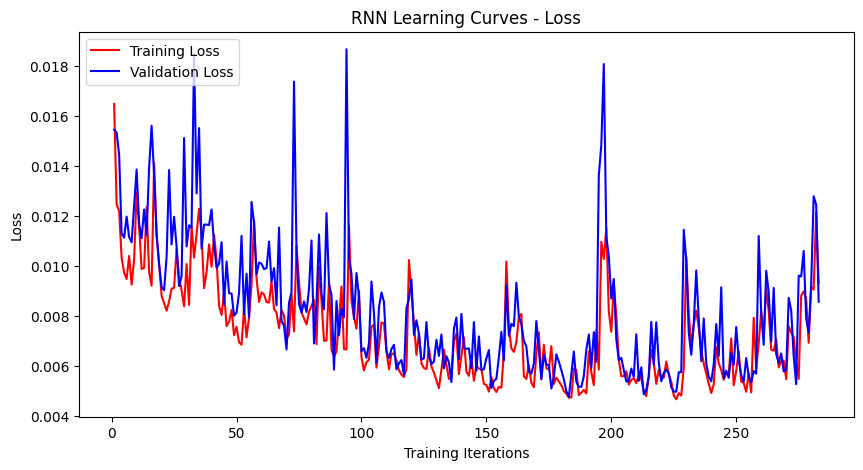

Test loss: 0.006769882566812966


In [458]:
if HP['run_RNN']:

        # Create the RNN model
        model = RNNModelReg(RNNHP["input_dim"], RNNHP["hidden_dim"], RNNHP["layer_dim"], RNNHP["output_dim"]).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=RNNHP["lr"])
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"RNN Total number of parameters: {total_params}")

        # Train the RNN model
        train_losses, eval_losses= train_model(model, train_loader, val_loader, criterion, optimizer, epochs=RNNHP["epochs"], patience=RNNHP["patience"], savePath="logs/rnn.pth")
        plot_learning_curves(train_losses, eval_losses, "RNN Learning Curves")
        evaluate(model, test_loader, criterion)




## LSTM training

LSTM Total number of parameters: 11153
Val loss: 0.017244938885172208
Epoch 1/500, Train Loss: 0.02383781, Val Loss: 0.01724494
Val loss: 0.014425371090571086
Epoch 2/500, Train Loss: 0.01427094, Val Loss: 0.01442537
Val loss: 0.013158427799741428
Epoch 3/500, Train Loss: 0.01304634, Val Loss: 0.01315843
Val loss: 0.012417055231829484
Epoch 4/500, Train Loss: 0.01133772, Val Loss: 0.01241706
Val loss: 0.01014360807215174
Epoch 5/500, Train Loss: 0.01010512, Val Loss: 0.01014361
Val loss: 0.011447162088006734
Epoch 6/500, Train Loss: 0.00950358, Val Loss: 0.01144716
Val loss: 0.00761644405623277
Epoch 7/500, Train Loss: 0.00835270, Val Loss: 0.00761644
Val loss: 0.007747313069800536
Epoch 8/500, Train Loss: 0.00695703, Val Loss: 0.00774731
Val loss: 0.0064224347472190855
Epoch 9/500, Train Loss: 0.00650988, Val Loss: 0.00642243
Val loss: 0.006775160972028971
Epoch 10/500, Train Loss: 0.00679145, Val Loss: 0.00677516
Val loss: 0.006318029357741276
Epoch 11/500, Train Loss: 0.00645000, Va

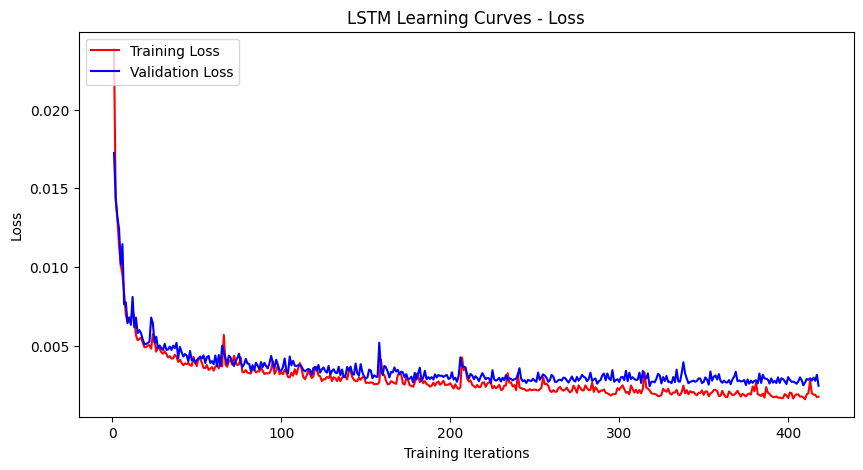

In [433]:
if HP['run_LSTM']:
        # Create the LSTM model
        model = LSTMModelReg(LSTMHP["input_dim"], LSTMHP["hidden_dim"], LSTMHP["layer_dim"], LSTMHP["output_dim"]).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LSTMHP["lr"])
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"LSTM Total number of parameters: {total_params}")
        # Train the LSTM model
        train_losses, eval_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=LSTMHP["epochs"], patience=LSTMHP["patience"])
        plot_learning_curves(train_losses, eval_losses, "LSTM Learning Curves")
        

In [434]:
evaluate(model, test_loader, criterion)

Test loss: 0.0021461250079381797


0.0021461250079381797

# Visualizing model predictions

The model has 11,651 trainable parameters
loss is: 0.0066003017127513885
Comparing predictions with output:
 y_pred
tensor([[ 1.9710,  1.1834, -0.4136],
        [ 1.5573,  0.9004, -0.2072],
        [ 1.6763,  0.9966, -0.5944],
        [ 1.4205,  0.9584, -0.6288],
        [ 1.1891,  0.8236, -0.6517],
        [ 1.0359,  0.8490, -0.8948],
        [ 0.8217,  0.7086, -1.0486],
        [ 0.6469,  0.6658, -1.1576],
        [ 0.5667,  0.6158, -1.1897],
        [ 0.4838,  0.4847, -1.3012],
        [ 0.4644,  0.4990, -1.4862],
        [ 0.3769,  0.3889, -1.5598],
        [ 0.3372,  0.3363, -1.6911],
        [ 0.3030,  0.3316, -1.7874],
        [ 0.2976,  0.3191, -1.8181],
        [ 0.2808,  0.3195, -1.8290],
        [ 0.2939,  0.3367, -1.8464],
        [ 0.2933,  0.3237, -1.8569],
        [ 0.2705,  0.3272, -1.8553],
        [ 0.2860,  0.3324, -1.8535],
        [ 0.2750,  0.3244, -1.8488],
        [ 0.2647,  0.3207, -1.8567],
        [ 0.2786,  0.3306, -1.8557],
        [ 0.2640,  0.3176, -1.845

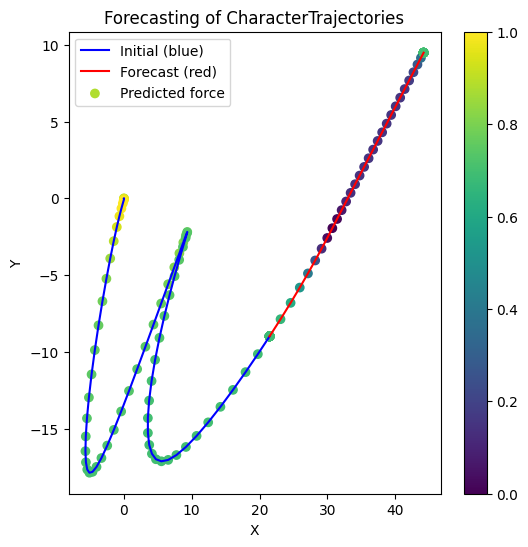

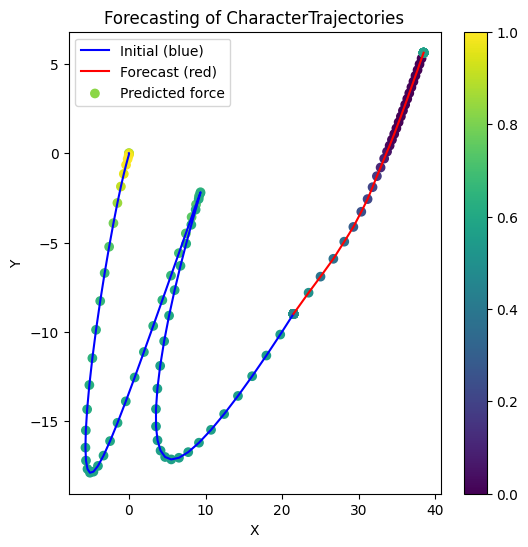

In [462]:
def strip_time(x):
    # Strip time channel
    x = x[:, :, 1:]
    # Get mask of y (where all values are zero)
    mask = x == 0
    mask = ~mask
    return x, mask

def plot_trajectory(x_batch, pred_y, id):
    pred_y = pred_y.cpu().detach().numpy()
    x_batch = x_batch.cpu().detach().numpy()

    pred_y = pred_y[id]
    x_batch = x_batch[id]

    # x_batch = x_batch[:, 1:]

    pred_y = np.concatenate([x_batch, pred_y], axis=0)

    # Plot predicted trajectory and ground truth trajectory
    pred_vx, pred_vy, pred_f = [pred_y[: , i] for i in range(3)]

    # Integrate velocities to get positions
    pred_x, pred_y = np.cumsum(pred_vx), np.cumsum(pred_vy)

    # Remove last element and insert 0 to the beginning
    pred_x, pred_y = np.insert(pred_x[:-1], 0, 0), np.insert(pred_y[:-1], 0, 0)

    # Handle NaN values by only considering non-NaN values for normalization
    min_value, max_value = np.nanmin(pred_f), np.nanmax(pred_f)
    pred_f_normal = (pred_f - min_value) / (max_value - min_value)

    # Determine index for splitting the line into two segments
    split_index = int(0.7 * len(pred_x))

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(pred_x[:split_index], pred_y[:split_index], label='Initial (blue)', color='blue')
    plt.plot(pred_x[split_index:], pred_y[split_index:], label='Forecast (red)', color='red')
    plt.scatter(pred_x, pred_y, c=pred_f_normal, cmap='viridis', label='Predicted force')
    plt.colorbar()
    plt.legend()
    plt.title('Forecasting of CharacterTrajectories')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# # Define model
# model = LSTMModelReg(LSTMHP["input_dim"], LSTMHP["hidden_dim"], LSTMHP["layer_dim"], LSTMHP["output_dim"]).to(device)

# # Load model
# model.load_state_dict(torch.load('logs/lstm500epochED.pth'))

# Define model
model = RNNModelReg(RNNHP["input_dim"], RNNHP["hidden_dim"], RNNHP["layer_dim"], RNNHP["output_dim"]).to(device)

# Load model
model.load_state_dict(torch.load('logs/rnn.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

b = 15
x_batch, y_batch, lengths = next(iter(test_loader))
with torch.no_grad():
        
    # for x_batch, y_batch, lengths in test_loader:
        
        y_lengths = getLenghts(y_batch)  
        
        # Processing the entire x_batch through the model to get the initial hidden state and outputs
        outputs, hidden = model(x_batch, lengths)
        
        # Select the last valid output for each sequence in the batch as the initial current input
        # print(f"input to evaluate, x_batch: {x_batch.shape}, lengths (of x): {lengths}, lengths (of y): {y_lengths} ")
        current_inputs = torch.stack([outputs[i, length-1, :] for i, length in enumerate(lengths)]).unsqueeze(1)
        # print(f"Outputs: {outputs.shape}, current_input: {current_inputs.shape}\n{current_inputs[:5,0,:]} ")

        # Initialize the placeholder for the entire sequence prediction
        y_pred_seq = torch.zeros_like(y_batch).to(device)
        
        # Set the first timestep predictions to the last output of x_batch
        for i in range(x_batch.size(0)):
            if y_lengths[i] > 0:  # Check if there's at least one timestep to predict
                y_pred_seq[i, 0, :] = current_inputs[i, 0, :]
        
        max_pred_length = max(y_lengths).item()  # Assuming y_lengths is correctly defined
        current_length = torch.tensor([1] * x_batch.size(0))  # Each step is length 1
        for t in range(1, max_pred_length):  # Loop over the maximum prediction length across the batch
            output, hidden = model(current_inputs, current_length, hidden)
            current_inputs = output.clone()  # Prepare next input
            
            # Update predictions within the target length for each sequence
            for i, y_len in enumerate(y_lengths):
                if t < y_len:  # Check if the current timestep is within the target sequence length
                    y_pred_seq[i, t, :] = output[i, :, :]

        loss = criterion(y_pred_seq, y_batch) / len(y_batch)
        print(f"loss is: {loss.item()}")
        # if b == 0:  # Print comparison for the first batch
        print(f"Comparing predictions with output:\n y_pred\n{y_pred_seq[b,:,:]} \ny_batch\n{y_batch[b,:,:]}")


# groud truth
# y_batch, mask = strip_time(y_batch)
plot_trajectory(x_batch, y_batch, b)

# prediction
# Get mask of batch_y (where all values are zero)
# y_batch, mask = strip_time(y_batch)
# Apply mask to pred_y
# y_pred_seq = y_pred_seq * mask
plot_trajectory(x_batch, y_pred_seq, b)